In [1]:
import time
import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('dark_background')

### 1) Classical Monte Carlo

In [2]:
def simple_monte_carlo(initial_stock_price, strike_price, time_to_maturity, 
                       risk_free_interest_rate, dividend_rate, 
                       volatility, option_type, time_steps_count, samples_count):
    
    rate_difference = risk_free_interest_rate - dividend_rate
    
    # Stock prices
    
    samples = np.zeros(samples_count) 
    time_step = time_to_maturity/time_steps_count
    
    weights = np.random.standard_normal(size=(samples_count, time_steps_count))
    
    samples = weights.sum(axis=1) * np.sqrt(time_step)  

    stock_prices = initial_stock_price * np.exp((rate_difference - 0.5 * volatility ** 2) * time_to_maturity 
                                                + volatility * samples)
    
    # Option prices
    
    price_differences = stock_prices - strike_price   
    
    if option_type == 'Put':
        price_differences = -price_differences
    
    price_differences[price_differences < 0] = 0
    
    option_prices = price_differences * np.exp(-risk_free_interest_rate * time_to_maturity)
         
    return option_prices

In [3]:
def plot_asset_prices(initial_asset_prices, volatilities, asset_prices_meshgrid,
                       elevation=10, initial_azimuth=230):

    initial_asset_prices_grid, volatilities_grid = np.meshgrid(initial_asset_prices, volatilities)

    fig, ax = plt.subplots(figsize=(5, 5),
                           subplot_kw={"projection": "3d"})

    surface = ax.plot_surface(initial_asset_prices_grid,
                              volatilities_grid,
                              asset_prices_meshgrid.T,
                              cmap='plasma',
                              linewidth=30, 
                              antialiased=False)

    ax.view_init(elev=elevation, azim=initial_azimuth)

    ax.zaxis.set_rotate_label(False)
    
    ax.set_xlabel('Initial Asset Price')
    ax.set_ylabel('Volatility')
    ax.set_zlabel('Asset Price', rotation=90)
    
    plt.show()

In [4]:
# Fixed Parameters

T = time_to_maturity = 1

q = dividend_rate = 0.05
r = risk_free_interest_rate = 0.02

CallPut = option_type = 'Call'

#### 4) 101 Initial Prices - 101 Volatilities - 1M Samples - With Mean

In [5]:
DATASET_FILE = 'generated_prices/option_prices_1M_samples.csv'

initial_stock_prices = np.linspace(0, 10000, 101)
volatilities = np.linspace(0, 1.0, 101)

# samples_count = 10000
samples_count = 100

time_steps_count = 300

strike_price = 1000


fields_count = 3

option_prices_shape = (len(initial_stock_prices) * len(volatilities), fields_count)

option_prices = np.zeros(option_prices_shape)

option_prices_meshgrid_shape = len(initial_stock_prices), len(volatilities)

option_prices_meshgrid = np.zeros(option_prices_meshgrid_shape)


np.savetxt(DATASET_FILE, [],
           header='initial_stock_price,volatility,option_price',
           comments='')

simulation_tracker = tqdm.tqdm(
    initial_stock_prices,
    desc=f"Simulating",
    ncols=110,
    unit='simulation',
    mininterval=1    
)    

for initial_stock_price_index, initial_stock_price in enumerate(simulation_tracker):

    for volatility_index, volatility in enumerate(volatilities):

        sampled_option_prices = simple_monte_carlo(
            initial_stock_price=initial_stock_price, 
            strike_price=strike_price,
            time_to_maturity=time_to_maturity, 
            risk_free_interest_rate=risk_free_interest_rate,
            dividend_rate=dividend_rate, 
            volatility=volatility, 
            option_type=option_type, 
            time_steps_count=time_steps_count,
            samples_count=samples_count
        )
        
        option_price = sampled_option_prices.mean()
        
        # row = np.array([initial_stock_price, volatility, option_price])
        
        row = (initial_stock_price, volatility, option_price)
        
        option_price_index = initial_stock_price_index * len(initial_stock_prices) + volatility_index
        
        option_prices[option_price_index] = row
        
        # print(row)
           
        # Meshgrid
        
        option_prices_meshgrid[initial_stock_price_index, volatility_index] = option_price
        

with open(DATASET_FILE, 'ab') as dataset_file:
    np.savetxt(dataset_file, option_prices, fmt=('%d', '%f', '%f'), delimiter=',')

Simulating: 100%|███████████████████████████████████████████████████| 101/101 [00:05<00:00, 17.71simulation/s]


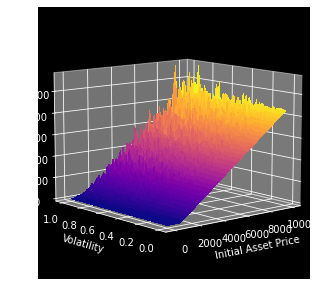

In [8]:
plot_asset_prices(initial_stock_prices, volatilities, option_prices_meshgrid)

### 2) JAX Monte Carlo

In [15]:
# !pip install --upgrade "jax[cuda]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [2]:
# Host CPUs

import os

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'

# JAX

import jax
import jax.numpy as jnp

from jax.config import config

config.update("jax_enable_x64", True)

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"] = ", ".join(map(str, range(6, 16)))

jax.devices()

# os.environ

In [4]:



# GPUs

import os



# jax.devices()

In [ ]:
def test_mc(S, K, T, r, q, sigma, CallPut, n, m):
    
    return (S, K, T, r, q, sigma, n, m)


def test_mc_simple(S, T):
    
    return S

initial_stock_price = 1000
strike_price = 100
volatility = 0.5

result = test_mc(S=initial_stock_price, 
                 K=strike_price,
                 T=time_to_maturity, 
                 r=risk_free_interest_rate,
                 q=dividend_rate, 
                 sigma=volatility, 
                 CallPut=option_type, 
                 n=time_steps_count,
                 m=paths_count)

print("Result:", result)


initial_stock_prices = jnp.array([1000, 2000])

vmapped_test_mc = jax.vmap(test_mc,
                           in_axes=(0, None, None, None, None, None, None, None, None))

vmapped_result = vmapped_test_mc(initial_stock_prices, 
                 strike_price,
                 time_to_maturity, 
                 risk_free_interest_rate,
                 dividend_rate, 
                 volatility, 
                 option_type, 
                 time_steps_count,
                 paths_count)


print("vmapped_result:", vmapped_result)

In [ ]:
def test_function(a, b, c):
    
    return a + b + c

vmapped_test_function = jax.vmap(test_function,
                                 in_axes = (0, None, 0))

a_s = jnp.array([0, 1])
b_s = 10
c_s = jnp.array([100, 200])

result = vmapped_test_function(a_s, b_s, c_s)

print("Result:", result)

In [ ]:
vmapped_mc = jax.vmap(monte_carlo,
                      in_axes=(0, None, None, None, None, None, None, None, None))

initial_stock_prices = jnp.array([1000, 2000])
strike_price = 100
volatility = 0.5

result = vmapped_mc(S=initial_stock_prices, 
                     K=strike_price,
                     T=time_to_maturity, 
                     r=risk_free_interest_rate,
                     q=dividend_rate, 
                     sigma=volatility, 
                     CallPut=option_type, 
                     n=time_steps_count,
                     m=paths_count)

print("Result:", result)

# ,
                                # axis_name='filters',
                                # static_broadcasted_argnums=[2, 3, 4, 6, 7, 8],
                                # in_axes=(None, 0, None),
                               # )
    
#     result = vmapped_function()
    
#     result = vmapped_function(S=initial_stock_prices, 
#                                   K=strike_prices,
#                                   T=time_to_maturity, 
#                                   r=risk_free_interest_rate,
#                                   q=dividend_rate, 
#                                   sigma=volatilities, 
#                                   CallPut=option_type, 
#                                   n=time_steps_count,
#                                   m=paths_count)
    
#     continue